In [8]:
import numpy as np
import matplotlib.pyplot as plt

from rfest.MF import semiNMF
from rfest._splines import build_spline_matrix

## Simulated Subunits

In [138]:
def gaussian(dims, sigma, mu):
    
    import numpy as onp
    
    if len(dims) == 1:
        
        x = dims[0]
        xx = onp.arange(x)
        
        gaussian_filter = 1/(sigma*onp.sqrt(2*onp.pi))*onp.exp(-1*(xx-mu)**2/ (2*sigma**2) )
        gaussian_filter = gaussian_filter.reshape(*dims, 1)
        
    else:
        
        if 1 < len(dims) < 3:
        
            x = dims[0]
            y = dims[1]
            
        elif len(dims) > 2:
            
            y = dims[1]
            x = dims[2]
        
        sigx = sigma[0]
        sigy = sigma[1]
        
        mux = mu[0]
        muy = mu[1]
        
        xx, yy = onp.meshgrid(onp.arange(0, y), onp.arange(0, x))
        
        gaussian_window = onp.exp(-0.5 * (((xx - mux) / sigx)**2 + ((yy - muy) / sigy)**2))
        gaussian_filter = 0.5 * gaussian_window / (0.5 * onp.pi * (sigx + sigy) ** 2)
        gaussian_filter = 0.25 * gaussian_filter / gaussian_filter.max()
        gaussian_filter = gaussian_filter.T
    
    return gaussian_filter.T

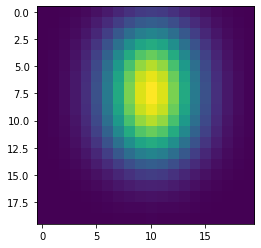

In [148]:
dims = [20, 20]

k0 = gaussian(dims, [3,3], [10, 10])
k1 = gaussian(dims, [3,3], [10, 5])

plt.imshow(k0+k1)

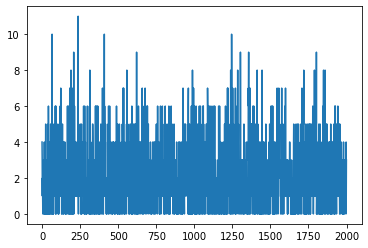

In [197]:
def nonlin(x):
    return np.log(1+np.exp(x))+1e-7

dt = 1
n = np.prod(dims) * 5
X = np.random.randn(n, *dims).reshape(n, np.prod(dims))

ci = nonlin(X @ k0.flatten()) + nonlin(X @ k1.flatten())
y = np.random.poisson(nonlin(ci) * dt)

plt.plot(y)

## Kmeans

In [198]:
def l2_distance(d, vec):    

    ret_val = np.sqrt(((d[:,:] - vec)**2.0).sum(axis=0))
            
    return ret_val.reshape((-1))

def pdist(A, B):
    # compute pairwise distance between a data matrix A (d x n) and B (d x m).
    # Returns a distance matrix d (n x m).
    d = np.zeros((A.shape[1], B.shape[1]))
    if A.shape[1] <= B.shape[1]:
        for aidx in range(A.shape[1]):
            d[aidx:aidx+1,:] = l2_distance(B[:,:], A[:,aidx:aidx+1]).reshape((1,-1))
    else:
        for bidx in range(B.shape[1]):
            d[:, bidx:bidx+1] = l2_distance(A[:,:], B[:,bidx:bidx+1]).reshape((-1,1))    
    return d

def vq(A, B):
    # assigns data samples in B to cluster centers A and
    # returns an index list [assume n column vectors, d x n]
    assigned = np.argmin(pdist(A,B), axis=0)
    return assigned


class KMeans:

    """

    Kmeans clustering. V = WH, where W is the cluster centroid, H the cluster labels.
    
    """

    def __init__(self, V, k=2, random_seed=2046, **kwargs):

        # build spline matrix, or not

        self.build_S = kwargs['build_S'] if 'build_S' in kwargs.keys() else False
        self.dims = kwargs['dims'] if self.build_S else None
        self.df = kwargs['df'] if self.build_S else None
        self.smooth = kwargs['smooth'] if 'smooth' in kwargs.keys() else 'cr'

        self.S = build_spline_matrix(self.dims, self.df, self.smooth) if self.build_S else None
        
        # store input data
        self.V = V # data
        
        # data shape / dimension
        self.m, self.n = V.shape
        self.k = k # number of subunits
        self.b = self.S.shape[1] if self.S is not None else None

        # initialize W and H

        np.random.seed(random_seed)

        self.H = np.zeros((self.n, self.k))
        self.W = self.V[:, np.sort(np.random.choice(range(self.n), self.k))]
        
    def update_W(self):
        
        V = self.V
        W = self.W
        H = self.H  
        S = self.S
        
        for i in range(self.k):
            # cast to bool to use H as an index for data
            idx = np.array(H[:, i], dtype=np.bool)
            n = np.sum(idx)
            if n > 0:
                W[:,i] = np.mean(V[:, idx], axis=1)
                
        if S is not None:
                        
            W0 = W.copy()
            
            B = np.linalg.lstsq(S, W0, rcond=None)[0]
            W = S @ B
            
        else:
            B = None
                
        return W, B
    
    def update_H(self):
        
        V = self.V
        W = self.W
        H = self.H
        
        assigned = vq(self.W, self.V)
        H = np.zeros(H.shape)
        H[range(self.n), assigned] = 1.0        
        
        return H
    
    def compute_cost(self):
        
        V = self.V
        W = self.W
        H = self.H
        WHt = W @ H.T
        
        return np.mean((V - WHt)**2)

    def fit(self, num_iters=300, verbal=0, tolerance=10):

        if verbal:
            self.cost = []
            self.iter = []
            print('{}\t{}'.format('Iter', 'Cost'))
        
        # start updating
        for itr in range(num_iters):

            self.W, self.B = self.update_W()
            self.H = self.update_H()

            if verbal:
                if itr % verbal == 0:
                    self.cost.append(self.compute_cost())
                    self.iter.append(itr)
                    print('{}\t{:.3f}'.format(itr, self.cost[-1])) 

                    if len(self.cost) >= tolerance and (np.abs(np.diff(self.cost[-tolerance:])) < 1e-7).all():
                        print('Stop: cost has been changing so small in the last ten chechpoint. Final cost = {:.3f}'.format(self.cost[-1]))
                        break
        else:
            if verbal:
                print('Stop: reached maximum iterations. Final cost = {:.3f}'.format(self.cost[-1]))

    

In [199]:
V = X[y!=0]

In [200]:
kms = KMeans(V.T, 2, build_S=True, dims=dims, df=7)

In [201]:
kms.fit(num_iters=1000, verbal=1, tolerance=100)

Iter	Cost
0	1.112
1	1.000
2	0.999
3	0.999
4	0.999
5	0.999
6	0.999
7	0.999
8	0.999
9	0.999
10	0.999
11	0.999
12	0.999
13	0.999
14	0.999
15	0.999
16	0.999
17	0.999
18	0.999
19	0.999
20	0.999
21	0.999
22	0.999
23	0.999
24	0.999
25	0.999
26	0.999
27	0.999
28	0.999
29	0.999
30	0.999
31	0.999
32	0.999
33	0.999
34	0.999
35	0.999
36	0.999
37	0.999
38	0.999
39	0.999
40	0.999
41	0.999
42	0.999
43	0.999
44	0.999
45	0.999
46	0.999
47	0.999
48	0.999
49	0.999
50	0.999
51	0.999
52	0.999
53	0.999
54	0.999
55	0.999
56	0.999
57	0.999
58	0.999
59	0.999
60	0.999
61	0.999
62	0.999
63	0.999
64	0.999
65	0.999
66	0.999
67	0.999
68	0.999
69	0.999
70	0.999
71	0.999
72	0.999
73	0.999
74	0.999
75	0.999
76	0.999
77	0.999
78	0.999
79	0.999
80	0.999
81	0.999
82	0.999
83	0.999
84	0.999
85	0.999
86	0.999
87	0.999
88	0.999
89	0.999
90	0.999
91	0.999
92	0.999
93	0.999
94	0.999
95	0.999
96	0.999
97	0.999
98	0.999
99	0.999
100	0.999
101	0.999
102	0.999
103	0.999
104	0.999
105	0.999
106	0.999
107	0.999
108	0.999
109	0.999


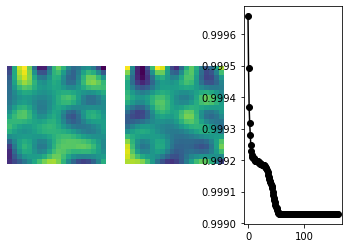

In [202]:
fig, ax = plt.subplots(1,3)
for i in range(2):
    ax[i].imshow(kms.W[:, i].reshape(dims))
    ax[i].axis('off')
    
ax[2].plot(kms.cost[1:], 'ko-')

array([[-0.01928944,  0.05881252, -0.09850016],
       [ 0.04801219,  0.05354084, -0.16688277],
       [-0.10604042, -0.01124305, -0.06489077],
       ...,
       [ 0.1160989 ,  0.00267824,  0.11995255],
       [-0.01515608, -0.00019542, -0.06260602],
       [-0.03071579, -0.04011083, -0.16252977]])

In [48]:
np.sort(np.random.choice(range(1500), 3))

array([ 398,  472, 1124])